In [84]:
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
from mordred import Calculator, descriptors, GeometricalIndex, TopologicalIndex 
from rdkit.Chem import Descriptors
from IPython.display import display
# sklearn and models for model training 
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# For fine tuning
from sklearn.model_selection import GridSearchCV

In [85]:
path_data = Path("../../Data/cleaned_data.xlsx")
dataset = pd.read_excel(path_data)
inital_shape = dataset.shape
print(inital_shape)

(19945, 2)


In [86]:
# Define a function to check if a SMILES contains only carbon
def contains_carbon(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        for atom in mol.GetAtoms():
            if atom.GetSymbol() != "C":
                return False
        return True
    except:
        return False

In [87]:
carbon_dataset = dataset[dataset['smiles'].apply(contains_carbon)]
carbon_dataset.shape

(866, 2)

In [88]:
# Counting the number of carbon for every molecule and add this number in a new column

# Function to count the number of carbon atoms in a molecule
def count_carbon(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    carbon_count = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 6)
    return carbon_count

# Add a new column 'carbon_count' to the DataFrame
carbon_dataset.loc[:, 'carbon_count'] = carbon_dataset['smiles'].apply(count_carbon)

C:\Users\rikim\AppData\Local\Temp\ipykernel_1644\963040561.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carbon_dataset.loc[:, 'carbon_count'] = carbon_dataset['smiles'].apply(count_carbon)


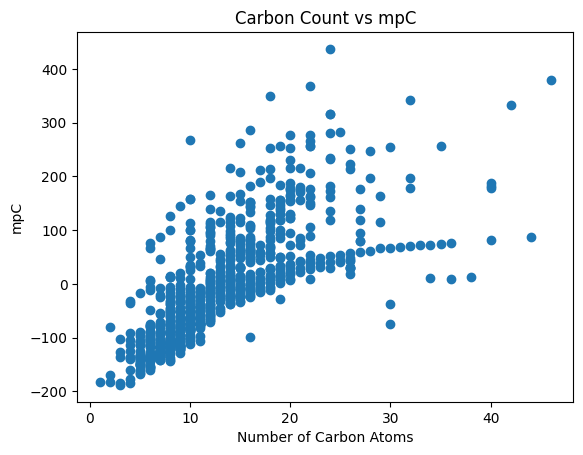

In [89]:
# Plot mpC vs Carbon_count

# Plotting
plt.scatter(carbon_dataset['carbon_count'], carbon_dataset['mpC'])
plt.xlabel('Number of Carbon Atoms')
plt.ylabel('mpC')
plt.title('Carbon Count vs mpC')
plt.show()

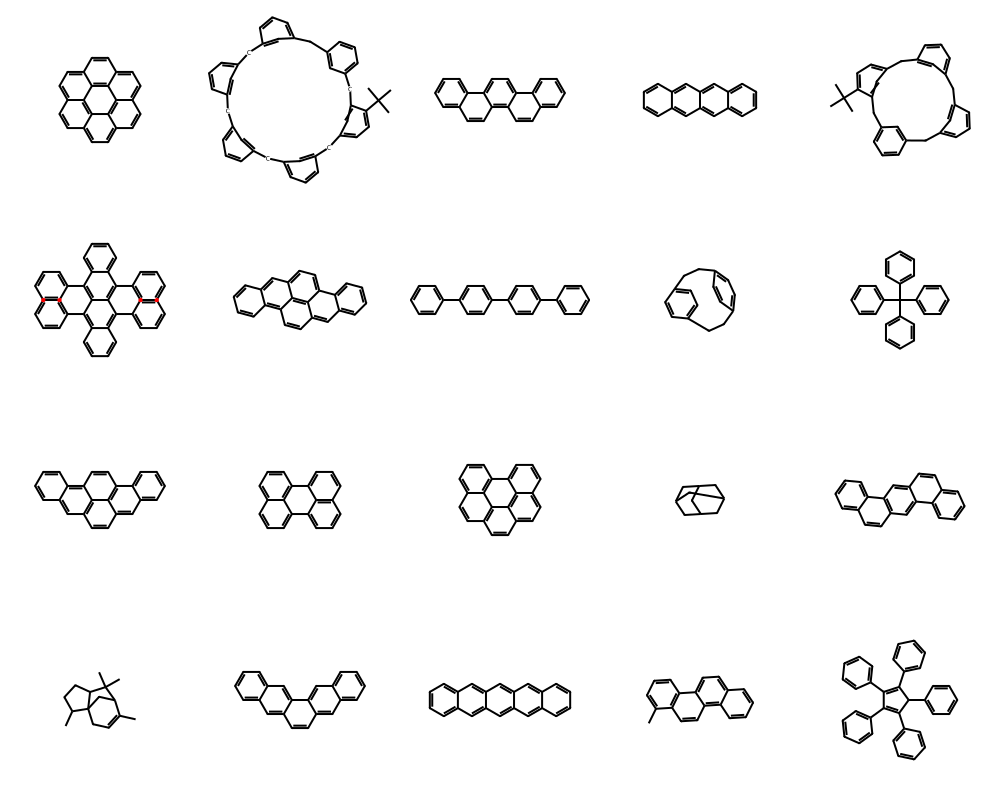

In [90]:
# See wich molecules have a high melting point

number_of_molecules_to_display = 20

# Sort the DataFrame by 'mpC' column in descending order
df_sorted = carbon_dataset.sort_values(by='mpC', ascending=False)

# Get the top 5 molecules
top_molecules = df_sorted.head(number_of_molecules_to_display)

# Generate RDKit Mol objects for the SMILES strings
mols = [Chem.MolFromSmiles(smiles) for smiles in top_molecules['smiles']]

# Draw the molecules in a grid
imge = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200))

# Display the image
display(imge)

In [107]:
# Let's remove molecules without benzene

# Function to check for benzene substructure
def has_benzene_substructure(smiles):
    mol = Chem.MolFromSmiles(smiles)
    benzene_substructure = Chem.MolFromSmarts('c1ccccc1')
    return mol.HasSubstructMatch(benzene_substructure)

# Add a new column 'has_benzene' to the DataFrame
carbon_dataset['has_benzene_sub'] = carbon_dataset['smiles'].apply(has_benzene_substructure)

C:\Users\rikim\AppData\Local\Temp\ipykernel_1644\917066303.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carbon_dataset['has_benzene_sub'] = carbon_dataset['smiles'].apply(has_benzene_substructure)


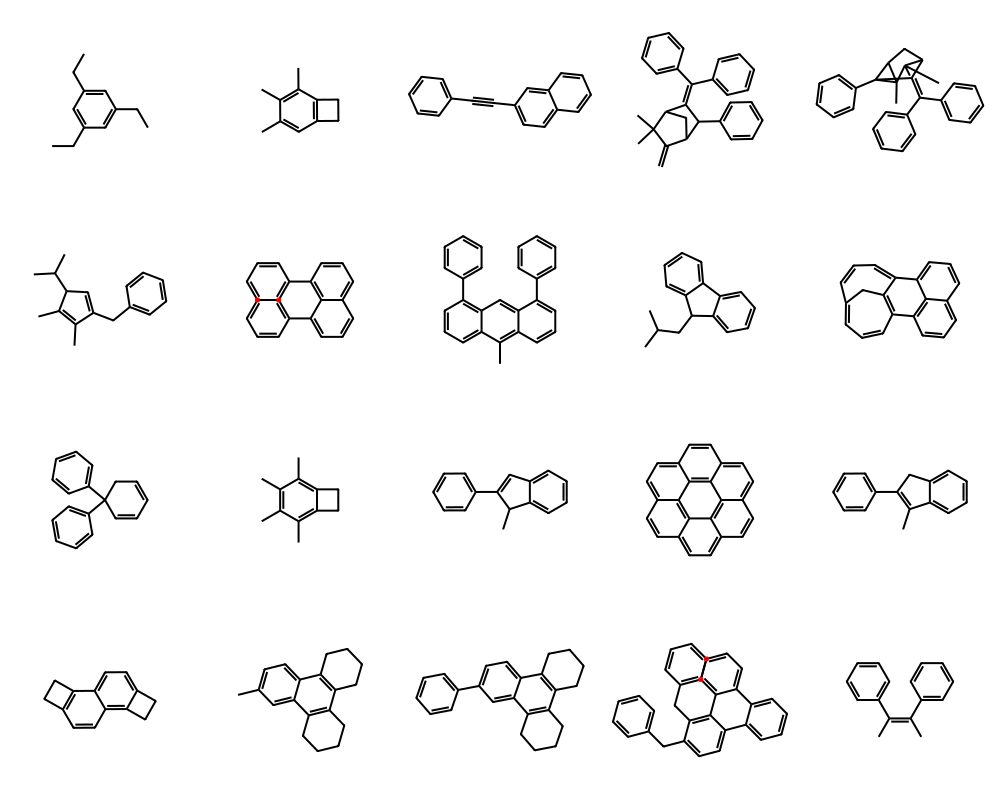

(380, 5)


In [108]:
dataset_benzene = carbon_dataset[carbon_dataset['has_benzene_sub'] == True]

# See wich molecules have a high melting point

number_of_molecules_to_display = 20

# Sort the DataFrame by 'mpC' column in descending order
df_sorted = carbon_dataset.sort_values(by='has_benzene_sub', ascending=False)

# Get the top 5 molecules
top_molecules = df_sorted.head(number_of_molecules_to_display)

# Generate RDKit Mol objects for the SMILES strings
mols = [Chem.MolFromSmiles(smiles) for smiles in top_molecules['smiles']]

# Draw the molecules in a grid
imge = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200))

# Display the image
display(imge)

print(dataset_benzene.shape)

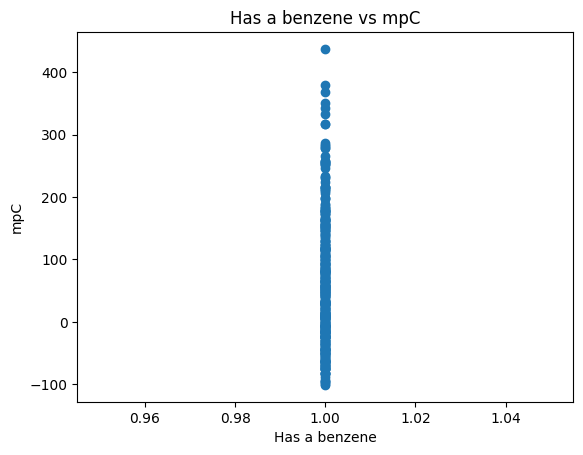

In [105]:
"""
# See the plot with benzene 

# Plotting
plt.scatter(dataset_benzene['has_benzene_sub'], dataset_benzene['mpC'])
plt.xlabel('Has a benzene')
plt.ylabel('mpC')
plt.title('Has a benzene vs mpC')
plt.show()
"""

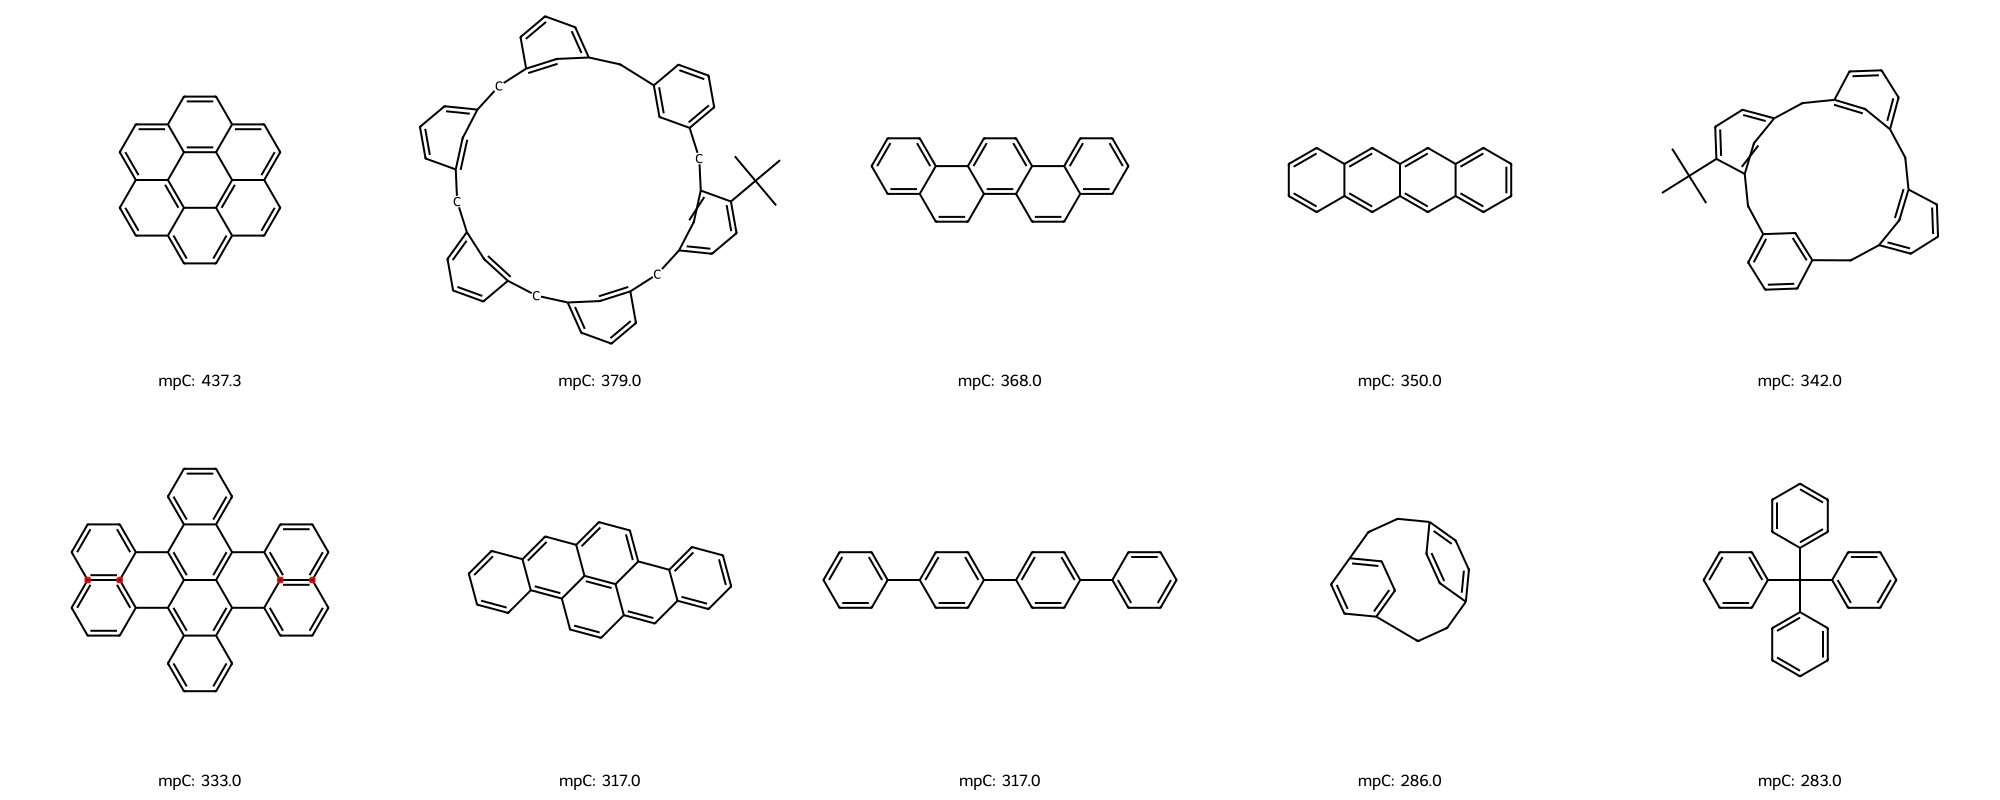

In [100]:
"""
# Number of molecules to display
number_of_molecules_to_display = 10

# Sort the DataFrame by 'mpC' column in descending order
df_sorted = dataset_benzene.sort_values(by='mpC', ascending=False)

# Get the top molecules
top_molecules = df_sorted.head(number_of_molecules_to_display)

# Generate RDKit Mol objects for the SMILES strings
mols = [Chem.MolFromSmiles(smiles) for smiles in top_molecules['smiles']]

# Create legend text with melting point values
legend_texts = [f"mpC: {mp}" for mp in top_molecules['mpC']]

# Draw the molecules in a grid with legend
img = Draw.MolsToGridImage(mols, legends=legend_texts, molsPerRow=5, subImgSize=(400, 400))

# Display the image
display(img)
"""

### We will now train a model for the non-benzene molecules, we first need descriptors

In [115]:
# Function to calculate all Mordred descriptors for a given SMILES string
def calculate_all_mordred_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    calc = Calculator(descriptors)
    mordred_descriptors = calc(mol)
    return mordred_descriptors.fill_missing().asdict()

# List to store dictionaries of descriptors for each molecule
descriptor_dicts = []

# Iterate over each SMILES string and calculate descriptors
for smiles in dataset_benzene['smiles']:
    descriptor_dict = calculate_all_mordred_descriptors(smiles)
    descriptor_dicts.append(descriptor_dict)

# Convert the list of dictionaries into a DataFrame
df_descriptors = pd.DataFrame(descriptor_dicts)

In [116]:
# Reset the indices of df and df_descriptors
dataset_benzene.reset_index(drop=True, inplace=True)
df_descriptors.reset_index(drop=True, inplace=True)

# Concatenate df and df_descriptors along the columns axis (axis=1)
df_combined = pd.concat([dataset_benzene, df_descriptors], axis=1)


In [118]:

# Save df_combined as an Excel file
df_combined.to_excel('benzene_descriptors.xlsx', index=False)


In [119]:
descriptors = df_combined.drop(columns=['smiles', 'mpC'])

In [120]:
# Calculate the variance for each column
column_variances = descriptors.var()

# Specify a threshold for variance
threshold = 0.1  # Adjust the threshold value as needed

# Filter out columns with variance below the threshold
columns_to_keep = column_variances[column_variances >= threshold].index

# Create a new DataFrame without low variance columns
df_high_variance = df_combined[columns_to_keep]

In [136]:
df_high_variance.shape

(380, 675)

In [137]:
df_combined.shape

(380, 1831)

In [138]:
df_combined

smiles   mpC  carbon_count  number_benzenes  \
0     CCCCCCc1ccc(cc1)C#Cc2ccc(cc2)C  42.0            21                0   
1    CCCCc1ccc(cc1)C#Cc2ccc(cc2)CCCC  41.0            22                0   
2                c1ccc(cc1)C2=CCCCC2 -11.0            12                0   
3                    Cc1cccc2c1cccc2 -22.0            11                0   
4              Cc1cccc-2c1Cc3c2cccc3  85.0            14                0   
..                               ...   ...           ...              ...   
375         C/C(=C/c1ccccc1)c2ccccc2  82.0            15                0   
376                 C/C(=CC)c1ccccc1 -23.5            10                0   
377        CC(/C=C/c1ccccc1)c2ccccc2  47.5            16                0   
378                    CCC=Cc1ccccc1 -43.1            10                0   
379          Cc2ccccc2/C=C/c1ccccc1C  83.0            16                0   

     has_benzene_sub  ABC  ABCGG  nAcid  nBase    SpAbs_A  ...     SRW10  \
0               True  NaN    NaN      0      0  27.155134  ...  9.471550   
1               True  NaN    NaN      0      0  28.775851  ...  9.527120   
2               True  NaN    NaN      0      0  16.383377  ...  9.076466   
3               True  NaN    NaN      0      0  14.495357  ...  9.284055   
4               True  NaN    NaN      0      0  18.912578  ...  9.734655   
..               ...  ...    ...    ...    ...        ...  ...       ...   
375             True  NaN    NaN      0      0  19.757720  ...  9.246962   
376             True  NaN    NaN      0      0  12.857279  ...  8.703009   
377             True  NaN    NaN      0      0  21.313564  ...  9.260558   
378             True  NaN    NaN      0      0  12.932143  ...  8.438366   
379             True  NaN    NaN      0      0  20.684128  ...  9.423434   

        TSRW10          MW       AMW  WPath  WPol  Zagreb1  Zagreb2  mZagreb1  \
0    53.684469  276.187801  6.137507   1208    25     98.0    107.0  6.194444   
1    54.909482  290.203451  6.045905   1371    27    102.0    112.0  6.444444   
2    42.338794  158.109550  6.081137    198    14     58.0     65.0  2.722222   
3    41.607772  142.078250  6.765631    140    15     56.0     65.0  3.083333   
4    60.783295  180.093900  6.926688    267    22     78.0     95.0  3.555556   
..         ...         ...       ...    ...   ...      ...      ...       ...   
375  46.327745  194.109550  6.693433    394    18     72.0     80.0  4.083333   
376  38.792641  132.093900  6.004268    121    11     44.0     48.0  3.722222   
377  47.520971  208.125201  6.503913    496    19     76.0     84.0  4.333333   
378  38.130322  132.093900  6.004268    133     9     42.0     44.0  3.111111   
379  47.902691  208.125201  6.503913    472    21     78.0     88.0  4.944444   

     mZagreb2  
0    4.916667  
1    5.250000  
2    2.777778  
3    2.472222  
4    3.027778  
..        ...  
375  3.444444  
376  2.444444  
377  3.694444  
378  2.500000  
379  3.638889  

[380 rows x 1831 columns]

In [139]:
selected_df = df_combined[["smiles", "mpC"]]
low_var_combined = pd.concat([selected_df, df_high_variance], axis=1)

In [143]:
low_var_combined.shape

(380, 677)

In [144]:

# Select rows where "nBondsKD" column equals 0
selected_rows = low_var_combined[low_var_combined['nBondsKD'] != 0]

# Reset the index of the selected rows
selected_rows.reset_index(drop=True, inplace=True)

In [145]:
selected_rows.shape

(380, 677)

In [146]:

selected_rows.to_csv("Aromatic_to_train.csv", index = False)

selected_rows = pd.read_csv("Aromatic_to_train.csv")

Random Forest Regressor - MSE: 2217.33, R2: 0.76


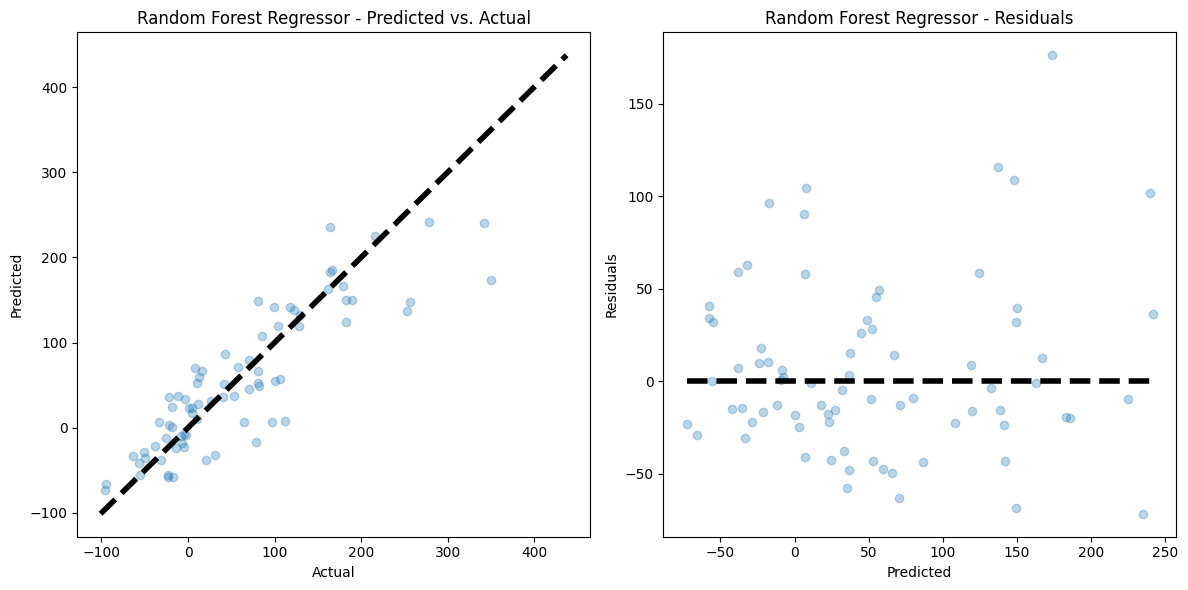

Gradient Boosting Regressor - MSE: 1791.36, R2: 0.81


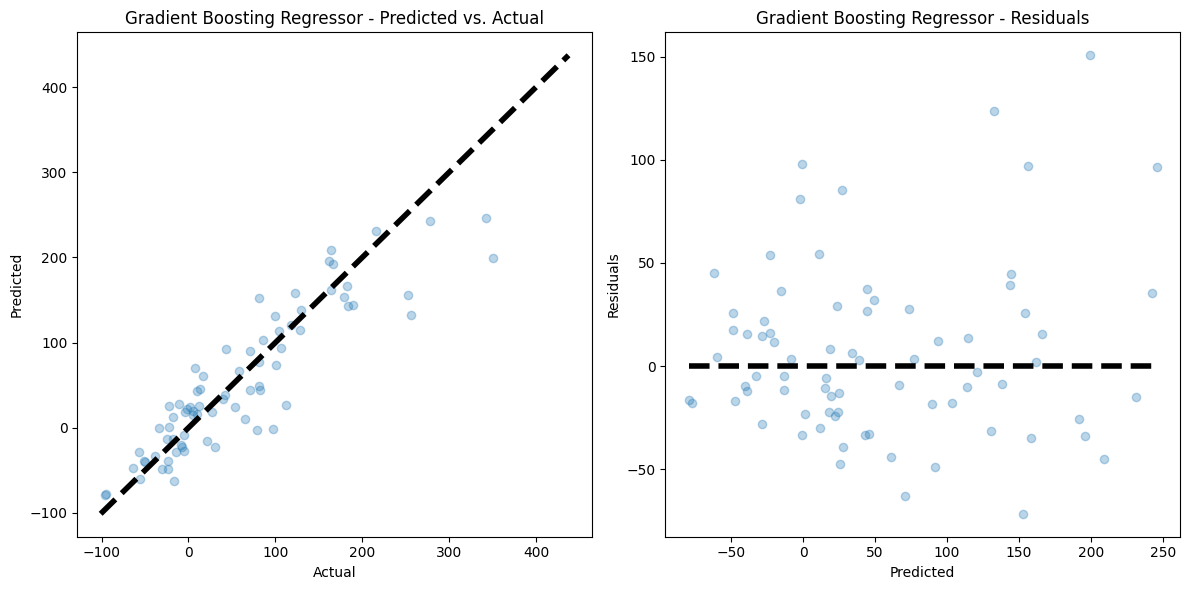

K Neighbors Regressor - MSE: 3154.88, R2: 0.66


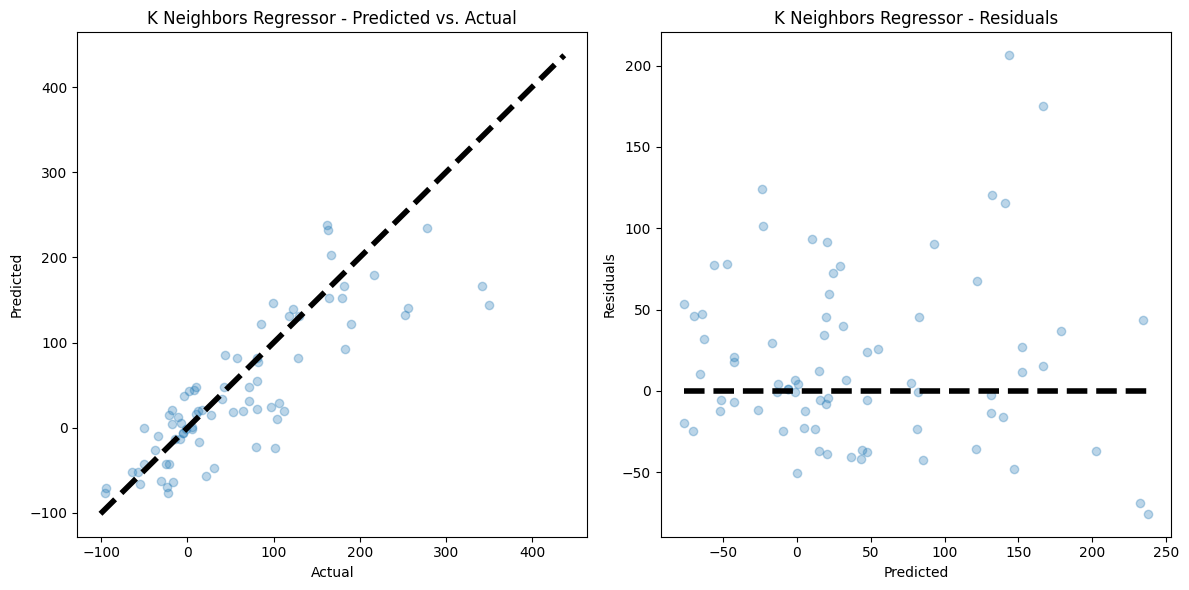

Decision Tree Regressor - MSE: 3709.46, R2: 0.60


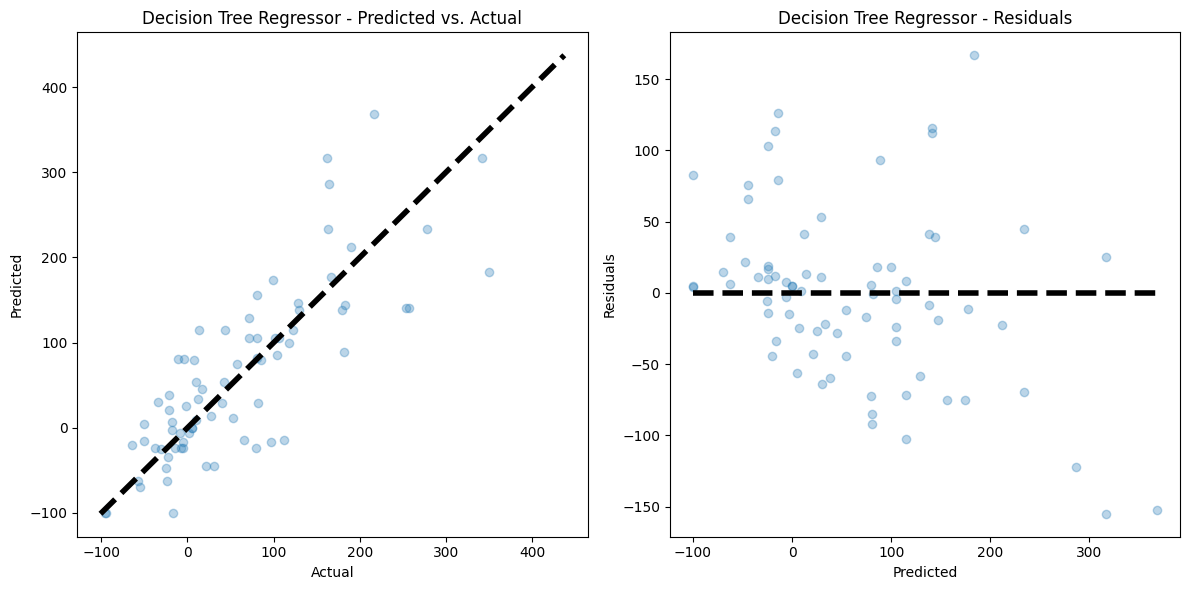

XGBoost - MSE: 2605.81, R2: 0.72


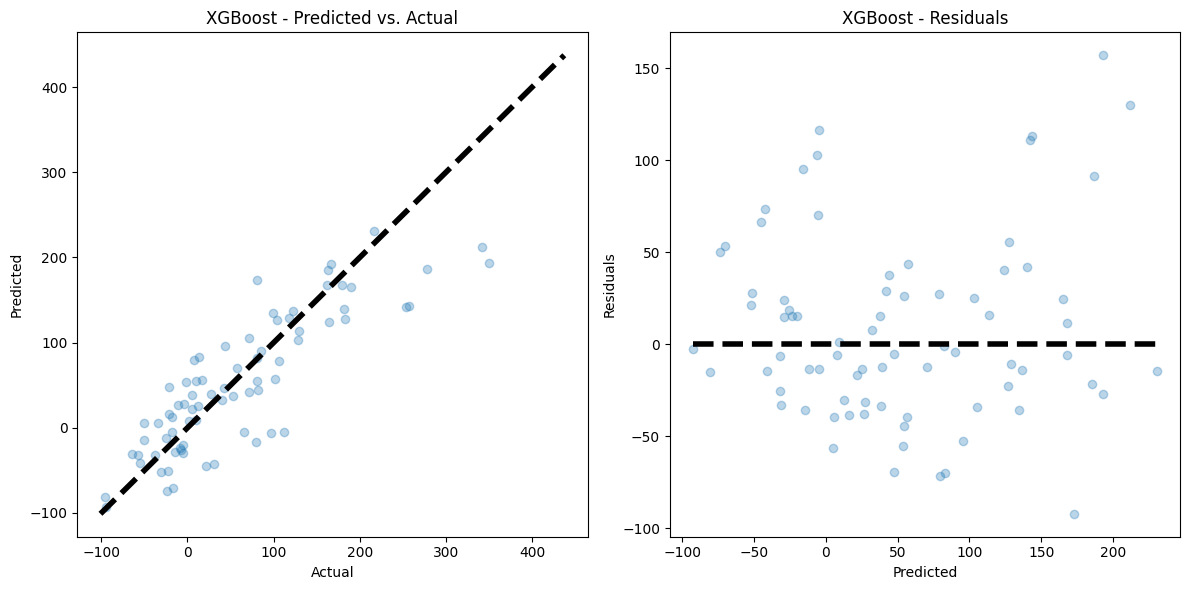

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44412
[LightGBM] [Info] Number of data points in the train set: 304, number of used features: 570
[LightGBM] [Info] Start training from score 60.336513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

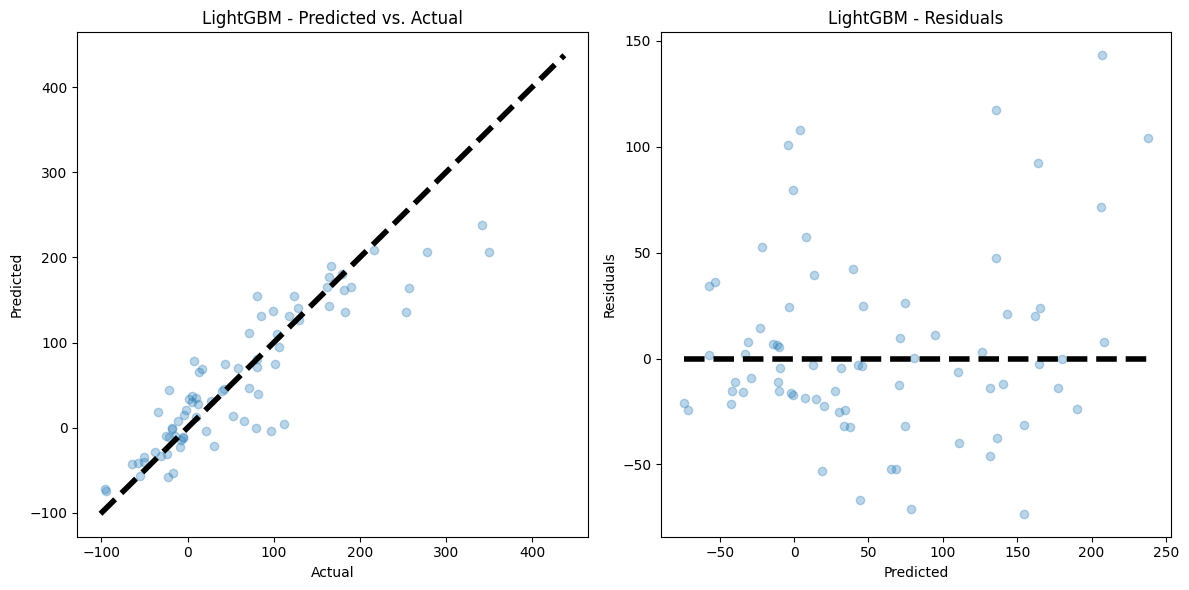

In [147]:
# Separating the features and the target variable
X = selected_rows.drop(columns=['smiles', 'mpC'])  # Features (descriptors)
X = X.dropna(axis='columns')
y = selected_rows['mpC']  # Target variable (Melting Point)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dictionary of models for ease of iteration
models = {
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'K Neighbors Regressor': KNeighborsRegressor(),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42)
}

# Training and evaluating each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - MSE: {mse:.2f}, R2: {r2:.2f}")

# Plotting Predicted vs Actual
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{name} - Predicted vs. Actual')
    
    # Plotting Residuals
    residuals = y_test - y_pred
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred, residuals, alpha=0.3)
    plt.plot([y_pred.min(), y_pred.max()], [0, 0], 'k--', lw=4)
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title(f'{name} - Residuals')
    
    plt.tight_layout()
    plt.show()

In [148]:
"""
# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the parameters grid to search
param_grid = {
    'n_estimators': [100, 200],  # You can try larger numbers if computational resources allow
    'max_depth': [None, 10, 20],  # None means no limit
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']  # 'auto' means all features
}

# Setup the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Best model
best_rf = grid_search.best_estimator_

# Predictions and evaluation
y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"After tuning - MSE: {mse:.2f}, R2: {r2:.2f}")
"""

Fitting 3 folds for each of 72 candidates, totalling 216 fits


C:\Users\rikim\miniconda3\envs\ppchem\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
108 fits failed out of a total of 216.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
52 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rikim\miniconda3\envs\ppchem\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rikim\miniconda3\envs\ppchem\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\rikim\miniconda3\envs\ppchem\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraint

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
After tuning - MSE: 2350.80, R2: 0.75


After tuning RandomForestRegressor - MSE: 2320.75, R2: 0.77


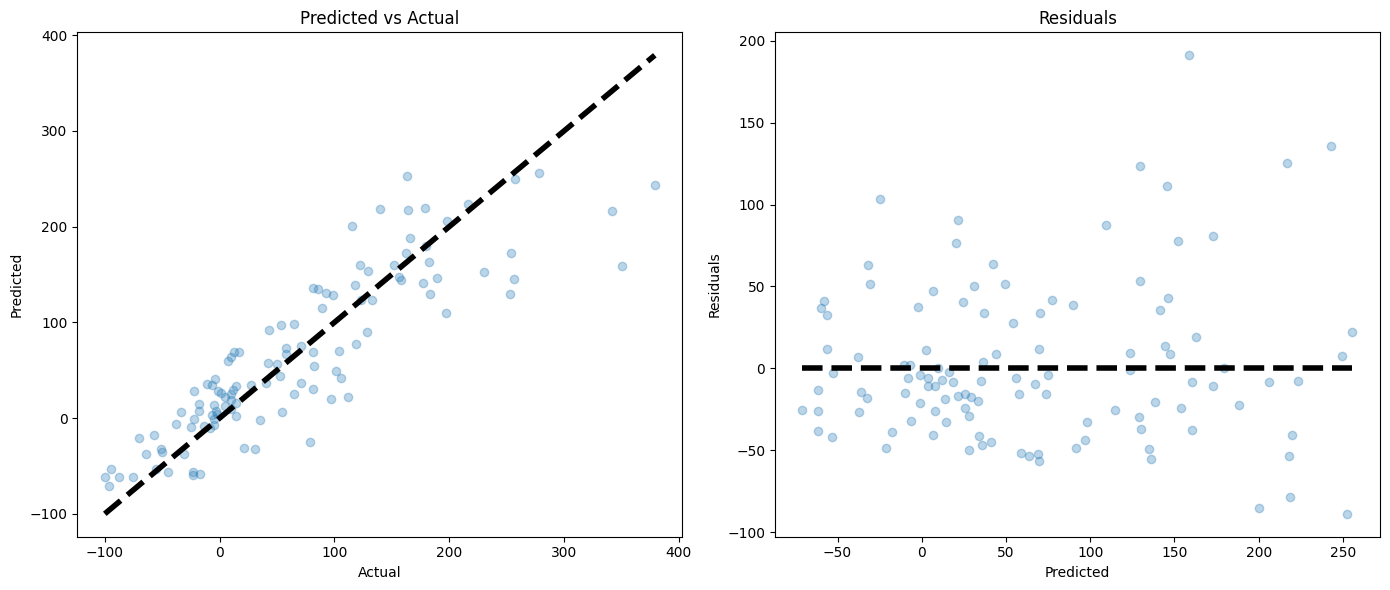

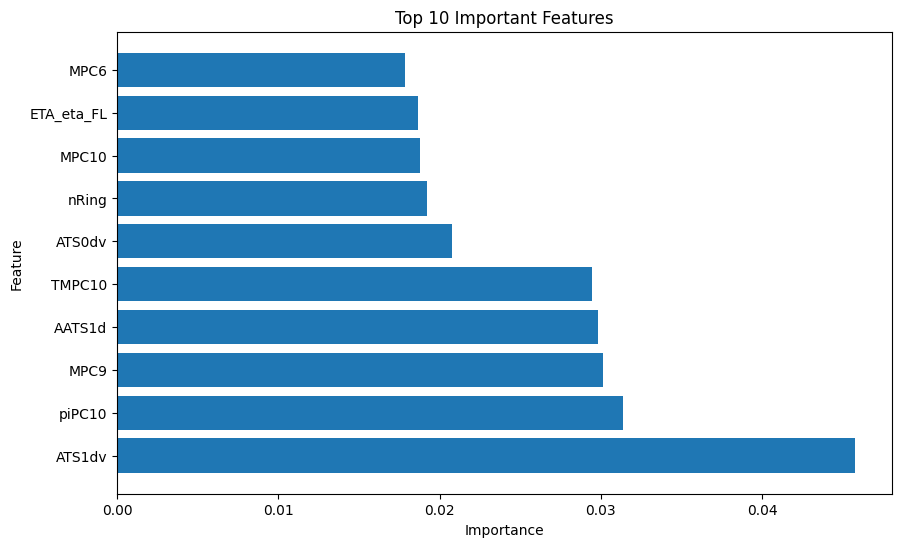

In [149]:
# visualize result for the best random forest model

# Separating the features and the target variable
X = selected_rows.drop(columns=['smiles', 'mpC'])  # Features (descriptors)
X = X.dropna(axis='columns')
y = selected_rows['mpC']  # Target variable (Melting Point)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the model with the best parameters
rf_best = RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100)

# Fit the model
rf_best.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_best.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"After tuning RandomForestRegressor - MSE: {mse:.2f}, R2: {r2:.2f}")

# Plotting Predicted vs Actual
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')

# Plotting Residuals
residuals = y_test - y_pred

plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.3)
plt.plot([y_pred.min(), y_pred.max()], [0, 0], 'k--', lw=4)  # Horizontal line
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals')

plt.tight_layout()
plt.show()

# Feature Importance
feature_importances = rf_best.feature_importances_
features = np.array(X_train.columns)
df_feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importances})
df_sorted = df_feature_importances.sort_values('importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(df_sorted['feature'], df_sorted['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features')
plt.show()


In [150]:
"""
# Define the model
gb = GradientBoostingRegressor(random_state=42)

# Define the parameters grid to search
param_grid = {
    'n_estimators': [100, 200],  
    'learning_rate': [0.01, 0.1],  
    'max_depth': [3, 5, 7],  
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
}

# Setup the grid search
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Best model
best_gb = grid_search.best_estimator_

# Predictions and evaluation
y_pred = best_gb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"After tuning - MSE: {mse:.2f}, R2: {r2:.2f}")
"""

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
After tuning - MSE: 1944.50, R2: 0.81


After tuning GradientBoostingRegressor - MSE: 1910.62, R2: 0.81


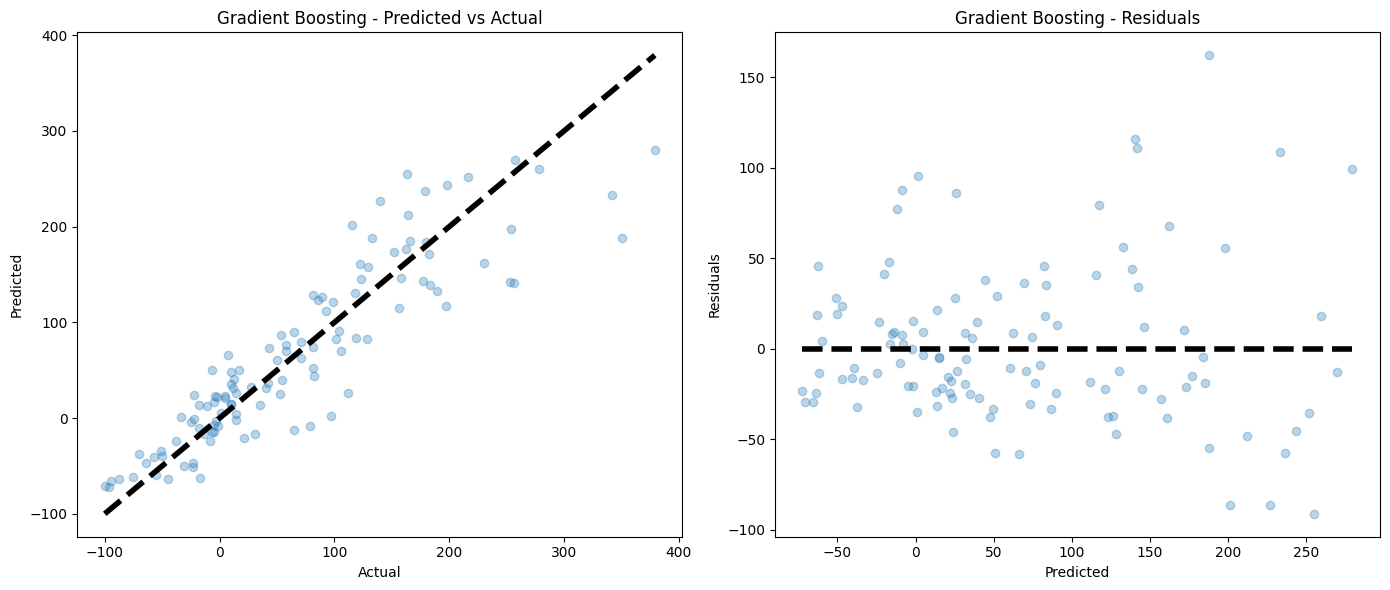

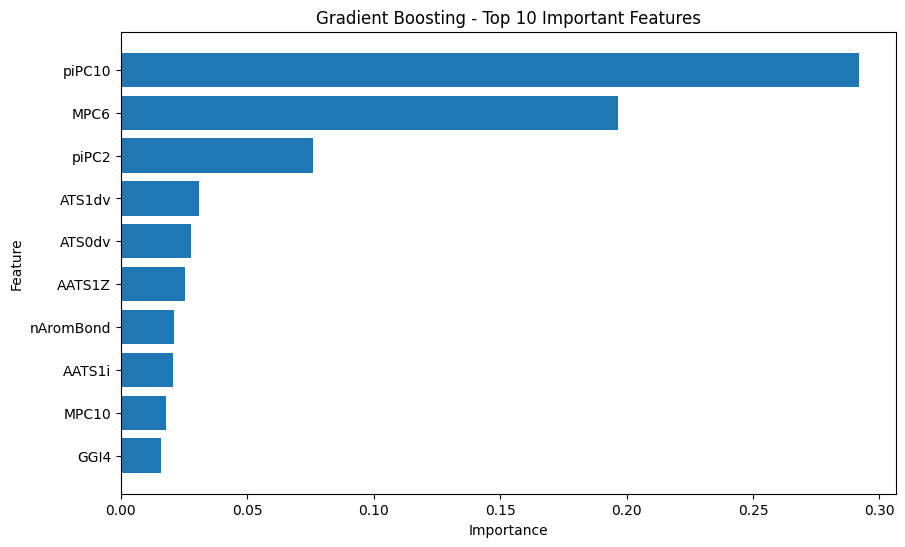

In [154]:
# Separating the features and the target variable
X = selected_rows.drop(columns=['smiles', 'mpC'])  # Features (descriptors)
X = X.dropna(axis='columns')
y = selected_rows['mpC']  # Target variable (Melting Point)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Creating the model with the best parameters
gb_best = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=100)

# Fitting the model
gb_best.fit(X_train, y_train)

# Predictions
y_pred_gb = gb_best.predict(X_test)

mse = mean_squared_error(y_test, y_pred_gb)
r2 = r2_score(y_test, y_pred_gb)
print(f"After tuning GradientBoostingRegressor - MSE: {mse:.2f}, R2: {r2:.2f}")

# Plotting Predicted vs Actual
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_gb, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Gradient Boosting - Predicted vs Actual')

# Plotting Residuals
residuals_gb = y_test - y_pred_gb

plt.subplot(1, 2, 2)
plt.scatter(y_pred_gb, residuals_gb, alpha=0.3)
plt.plot([y_pred_gb.min(), y_pred_gb.max()], [0, 0], 'k--', lw=4)  # Horizontal line
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Gradient Boosting - Residuals')

plt.tight_layout()
plt.show()

# Feature Importance
feature_importances_gb = gb_best.feature_importances_
df_feature_importances_gb = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances_gb})
df_sorted_gb = df_feature_importances_gb.sort_values('importance', ascending=False).head(10)

# Plotting Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(df_sorted_gb['feature'], df_sorted_gb['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Gradient Boosting - Top 10 Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

In [155]:
# Define and fit the model
basic_lgbm = LGBMRegressor(random_state=42)
basic_lgbm.fit(X_train, y_train)

# Predictions and evaluation
y_pred_basic = basic_lgbm.predict(X_test)
mse_basic = mean_squared_error(y_test, y_pred_basic)
r2_basic = r2_score(y_test, y_pred_basic)
print(f"Basic LGBM - MSE: {mse_basic:.2f}, R2: {r2_basic:.2f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38720
[LightGBM] [Info] Number of data points in the train set: 266, number of used features: 566
[LightGBM] [Info] Start training from score 57.182331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [156]:
"""
# Define the model
lgbm = LGBMRegressor(random_state=42)

# Define the parameters grid to search
param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [-1, 3],
    'num_leaves': [5,10],
    'min_child_samples': [20, 50]
}

# Setup the grid search
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=1, verbose=2, scoring='neg_mean_squared_error')

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Best model
best_lgbm = grid_search.best_estimator_

# Predictions and evaluation
y_pred_lgbm = best_lgbm.predict(X_test)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)
print(f"After tuning - MSE: {mse_lgbm:.2f}, R2: {r2_lgbm:.2f}")
"""

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27039
[LightGBM] [Info] Number of data points in the train set: 177, number of used features: 556
[LightGBM] [Info] Start training from score 54.979661
[CV] END learning_rate=0.01, max_depth=-1, min_child_samples=20, n_estimators=100, num_leaves=5; total time=   0.0s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26936
[LightGBM] [Info] Number of data points in the train set: 177, number of used features: 556
[LightGBM] [Info] Start training from score 54.862147
[CV] END learning_rate=0.01, max_depth=-1, min_child_samples=20, n_estimators=100, num_leaves=5; total time=   0.0s
[LightGBM] [Info] Aut

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38720
[LightGBM] [Info] Number of data points in the train set: 266, number of used features: 566
[LightGBM] [Info] Start training from score 57.182331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

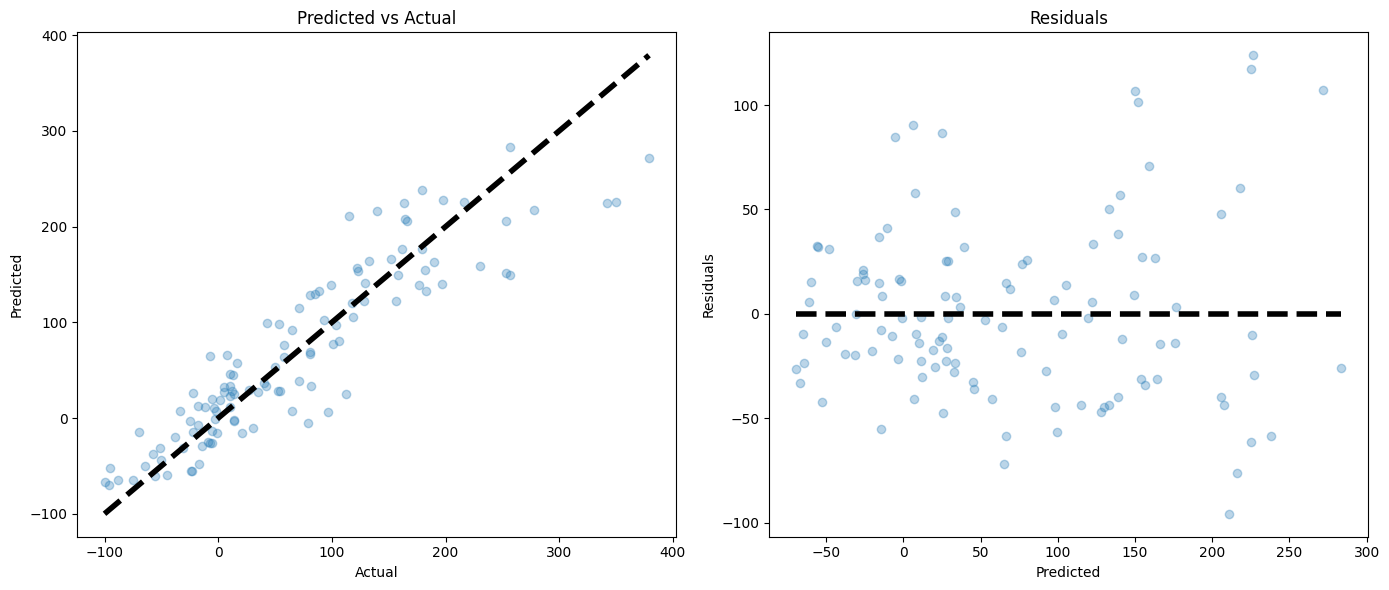

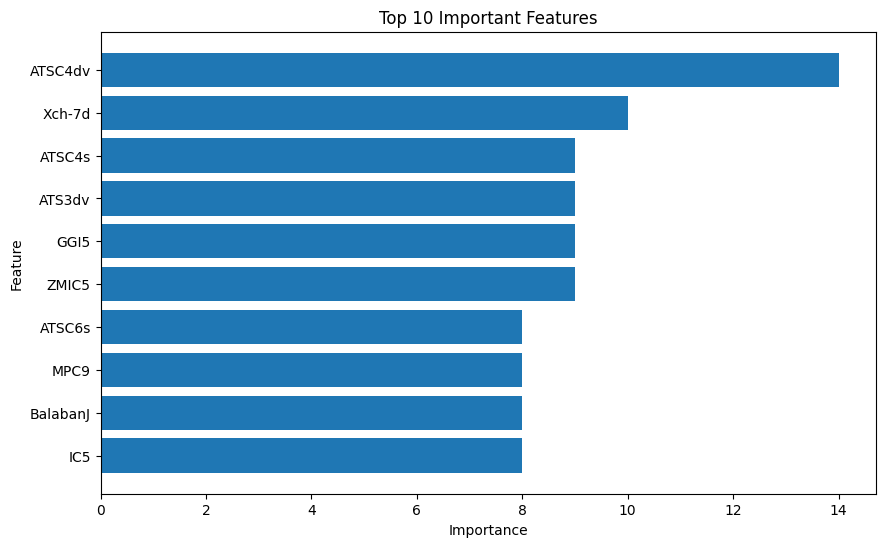

In [157]:
# Creating the model with the best parameters from the tuning (GRIDSEARCH RUN IN COLAB)
best_lgbm = LGBMRegressor(learning_rate=0.1, max_depth=3, min_child_samples=20, n_estimators=100, num_leaves=10)

# Fitting the model
best_lgbm.fit(X_train, y_train)

# Making predictions
y_pred = best_lgbm.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"After tuning GradientBoostingRegressor - MSE: {mse:.2f}, R2: {r2:.2f}")

# Plotting Predicted vs Actual
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')

# Plotting Residuals
residuals = y_test - y_pred

plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.3)
plt.plot([y_pred.min(), y_pred.max()], [0, 0], 'k--', lw=4)  # Horizontal line
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals')

plt.tight_layout()
plt.show()

# Feature Importance
feature_importances = best_lgbm.feature_importances_
features = np.array(X_train.columns)
df_feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importances})
df_sorted = df_feature_importances.sort_values('importance', ascending=False).head(10)

# Plotting Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(df_sorted['feature'], df_sorted['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()
